<img src='Static_figs/LSASAF_NoName_Colour.png' align='right' width='25%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:
* It is expected for the user to be familiar with Python
* It is expected, that **MSG MDFVC** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFVC/NETCDF/) in `NetCDF4` format for the periods November 2015 - August 2017 and for from April 2016 to November 2023 and saved locally
* It is expected, that **MSG FRP - Pixel** product data is downloaded from [LSA SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDFVC/NETCDF/) in `HDF5` format for the dates between June 17, 2017 and July 17, 2017 and in the period between July 7, 2022 and September 5, 2022.
</div>



<hr>

# Investigation of Effects of Wild Fires on Vegetation Using LSA SAF MSG MDFVC Product and LSA SAF MSG-FRP Pixel Product

#### About

Outbreaks of wildfires are often occurring in South Europe and therefore represent an important risk for the environment, vegetation as well as human lives and infrastructure. The Mediterranean climate, characterized by hot, dry summers and mild, wet winters, creates favorable conditions for the outbreak and rapid spread of fires, exacerbated by factors such as drought, high temperatures, and strong winds. Therefore a reliable detection of fires as well as an estimation of their severity and effect is of great importance when addressing the risk posed by wildifres.

The aim of this notebook is to investigate the power and evolution of the 3 major wildfires in the years 2017 and 2022 and their effect on vegetation. Firstly LSA SAF Fire Radiative Power (FRP) Pixel Product was used to calculate the total firepower of the fires, and then LSA SAF MDFVC product was used to detect potential impacts on vegetation since FVC is a good measure for the state of the vegetation.

#### Basic facts on the LSA SAF MDFVC
> **Product number**: LSA-421
>
> **Spatial resolution**: 3km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 1 day
> 
> **Data availability**: from 2016
>

#### Basic facts on the LSA SAF FRP - Pixel
> **Product number**: LSA-502
>
> **Spatial resolution**: 3km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 15 min
> 
> **Data availability**: from 2016
> 


#### Module outline:
* [1 - Accessing the Data](#First)
* [2 - Wildfire Power Estimation](#Second)
* [3 - FVC Estimation](#Third)
* [4 - Plotting](#Forth)

<hr>

#### Load required libraries

In [ ]:
import h5py
import numpy as np 
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm

### <a id='First'></a>1. Accessing the Data

It is assumed, that all the necessary data are already downloaded from [LSA SAF data server](https://landsaf.ipma.pt/en/data/netcdf-data-server/). The location of the files is specified.

In [2]:
FRP_LOCATION="Data_FRP/"
FVC_LOCATION="Data_FVC/"

LSA SAF product files are named with a rather complex naming convention. To make a code clear we define 2 functions, that return the filename of the LSA SAF product file for a particular date and hour.

In [3]:
def HDF5_FRP_name(time):
    '''
    Returns the name of LSA SAF MSG FRP List Pixel product
    HDF5 file from particular day and time.
    '''
    HDF5_name=FRP_LOCATION+"HDF5_LSASAF_MSG_FRP-PIXEL-ListProduct_MSG-Disk_"+time.strftime('%Y%m%d%H%M')
    return HDF5_name



In [4]:
def NETCDF4_FVC_name(time):
    '''
    Returns the name of LSA SAF MSG FVC product
    NetCDF4 file from particular day and time.
    '''
    import matplotlib.pyplot as plt
    NetCDF4_name=FVC_LOCATION+"NETCDF4_LSASAF_MSG_FVC_MSG-Disk_"+time.strftime('%Y%m%d%H%M')+".nc"
    return NetCDF4_name

LSA SAF MDFVC is available on a daily basis in booth `HDF5` and `NetCDF4`, while the FRP-Pixel List Product is only available as an `HDF5` file. The `NetCDF4` files can be manipulated directly in the Python library `xarray` while accessing and opening `HDF5` files is a little bit trickier and here achieved by using the `h5py` library-.

FRP List Product in  `HDF5` format is a group of datasets, fully described in the FRP Pixel product Product User Manual available [here](https://nextcloud.lsasvcs.ipma.pt/s/TjpsBziZFNN6GPN). The internal structure of the `HDF5` file can be investigated using appropriate software for instance [HDFView](https://www.hdfgroup.org/downloads/hdfview/) or an online tool [myHDF5](https://myhdf5.hdfgroup.org/), which doesn't require installation.

As mentioned, `HDF5` consists of multiple datasets. Essentially it is a list of all Meteosat Second Generation (MSG) satellites SEVIRI sensor pixels in which, the fire was detected, together with the properties of the detected fire (e.g. firepower), as well as some other attributes.

A function, that exports a list of datasets as a `pandas.DataFrame` was introduced, to simplify future work. 1-dimensional datasets from the `HDF5` file are exported as columns of a new `pandas.DataFrame`, which is more practical to work with in Python.

In [5]:
def get_HDF5_FRP_data(HDF5_filename, dataset_names):
    '''
    This function returns 1D Datasets of HDF5 file as a pd. dataframe
    '''
    # Create empty pd dataframe
    df=pd.DataFrame()

    # Load HDF5 file
    file=h5py.File(HDF5_filename, 'r')


    #Loop over datasets of the interest
    for i in range(len(dataset_names)):
        dset=file[dataset_names[i]]
        df[dataset_names[i]]=dset[:]*(1/dset.attrs["SCALING_FACTOR"])

    return df

### <a id='Second'></a>2. Wildfire Power Estimation

FRP List Product is a list of all active fires on the whole MSG disk at a particular time. It does not provide any simple way of grouping these pixels together to the fires at similar locations. Due to relatively large pixels, it is also not the most suitable to provide an estimate of the burnt area, compared to similar products based on the satellites in the lover orbit. Contrary it allows really good insight into the time evolution of wildifre, since FRP List Product is provided in real time every 15 min. 

In order, to determine which pixel from the List Product belongs to the fire of interest we need to filter the others out. This is achieved with the next function, which generates `pandas.DateFrame` and filters out entries, that are out of the lat-lon rectangle, in which the fire of the interest is located. Location, latitude and longitude limits therefore need to be sourced elsewhere than LSA SAF Products.

In this case [Copernicus Emergency Management Service - Mapping](https://emergency.copernicus.eu/mapping/copernicus-emergency-management-service#zoom=2&lat=13.56036&lon=33.82273&layers=00B0T) was used, to manually determine latitude and longitude ranges of particular fires.

In [6]:
def calculate_total_FRP(date, lat_min, lat_max, lon_min, lon_max):
    '''
    Function calculates total fire radiation power inside rectangle
    (lat_min-lat_max x lon_min-lon_max). 
    date=pd.datetime object
    output=Total FRP [MW]
    '''
    # Get a dataset of all pixels with active fire
    FRP_dataset=get_HDF5_FRP_data(HDF5_FRP_name(date), ["FRP", "FRP_UNCERTAINTY", "LATITUDE", "LONGITUDE"])

    # Drop entries with lat outside the range
    FRP_dataset=FRP_dataset[(FRP_dataset['LATITUDE'] > lat_min) & (FRP_dataset['LATITUDE'] < lat_max)]

    # Drop entries with lon outside the range
    FRP_dataset=FRP_dataset[(FRP_dataset['LONGITUDE'] > lon_min) & (FRP_dataset['LONGITUDE'] < lon_max)]
    
    # Sum all remaining FRP walues to get total FRP
    total_FRP=np.sum(FRP_dataset["FRP"].to_numpy())
    
    return(total_FRP)



### <a id='Third'></a>3. FVC Estimation

Fractional Vegetation Cover was estimated from MDFVC product in `NetCDF4` format. The function, that accesses the data and then calculates the average FVC value inside the lat-lon rectangle of the interest. We will later investigate the change in average FVC value in the rectangular area affected by the fire.

In [7]:
def calculate_average_FVC(date, lat_min, lat_max, lon_min, lon_max):
    '''
    Function calculates average FVC over rectangle (lat_min-lat_max x lon_min-lon_max).
    It ignores NaN walues.
    date=pd.datetime object
    output=average FVC
    '''
    FVC_ds=xr.open_dataset(NETCDF4_FVC_name(date))
    FVC_ds=FVC_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))["FVC"].load()
    FVC_np=FVC_ds.values[0,:,:]
    avg_FVC=np.nanmean(FVC_np)

    FVC_ds.close()
    return avg_FVC

### <a id='Forth'></a>4. Plotting

In order to investigate the change of FVC before and after the fire we need to extract it from the data with a `for` loop for all dates of the interest. The same needs to be done with FVC. We will extract FRP value for all measurements within 30 days from the beginning of the fire and FVC values one year before and after the fire, to detect long(er) term effects on the vegetation. This period can be adjusted by appropriate arguments while calling the function.

It is recommended to track potential errors, e.g. missing files, by setting the following parameter to `True`. In this example, it is omitted, since quite some FRP files are missing and the list of errors is too large.

In [8]:
SHOW_ERRORS=False

In [9]:
def analyse_fire(fire_start_date, lat_min, lat_max, lon_min, lon_max, fire_duration=30, FVC_time_before=365, FVC_time_after=365):
    '''
    Retunrs values of total FVC in the area and average FVC in the area.
    As default it returns FRP from start date for 30 days.
    As default it returns FVC value a year before and after the fire
    It returns "daycount": a number of days from the beggining of fire (negative before the start of fire)
    '''
    # We define FVC daterange and daycount (day 0 = start of the fire)
    FVC_datarange=pd.date_range(fire_start_date-dt.timedelta(days=FVC_time_before),fire_start_date+dt.timedelta(days=FVC_time_after),freq='1D', inclusive="left")
    FVC_daycount=np.arange(-FVC_time_before, FVC_time_after, 1)
    FVC_output=np.full(len(FVC_datarange), np.nan)

    # We define FRP daterange and daycount (day 0 = start of the fire)
    FRP_datarange=pd.date_range(fire_start_date,fire_start_date+dt.timedelta(days=fire_duration),freq='15T', inclusive="left")
    FRP_daycount=np.arange(0, fire_duration, 1/96)
    FRP_output=np.full(len(FRP_datarange), np.nan)

    # Loop over FVC data
    for i in tqdm(range(len(FVC_datarange))):
        try:
            FVC_output[i]=calculate_average_FVC(FVC_datarange[i],lat_min, lat_max, lon_min, lon_max)
        except:
            if SHOW_ERRORS:
                print("Problem with FVC value for the date: " +str(FVC_datarange[i]))

    #Loop over FRP data
    for i in tqdm(range(len(FRP_datarange))):
        try:
            FRP_output[i]=calculate_total_FRP(FRP_datarange[i],lat_min, lat_max, lon_min, lon_max)
        except:
            if SHOW_ERRORS:
                print("Problem with FRP value for the date: " +str(FRP_datarange[i]))

    # Set output
    return FVC_daycount, FVC_output, FRP_daycount, FRP_output
            

We can figure out the exact dates and locations from the [European Forest Fire Information System - EFFIS](https://effis.jrc.ec.europa.eu/). The start dates and locations are hard-coded in the following cell.

The 3 Wildfires will be investigated:
* The wildfire in Pedroago, Portugal which started on June 17,  2017, resulted in 66 deaths and approximately 50 000 ha of burnt area,
* The wildfire in the Kras region, Slovenia, which started on July 21, 2022, resulted in 2000 ha of burnt area.
* The wildfire in Covilhã, Portugal, which started on August 6, 2022, resulted in 4000 ha of burnt area.

In [ ]:
# Pedrogao
pedrogao_start_date=dt.datetime(2017, 6, 17, 0, 0, 0)
pedrogao_coordinates=[39.75, 40.25, -8.75, -7.5]
pedrogao_x_FVC, pedrogao_y_FVC, pedrogao_x_FRP, pedrogao_y_FRP=analyse_fire(
    pedrogao_start_date,
    pedrogao_coordinates[0],
    pedrogao_coordinates[1],
    pedrogao_coordinates[2],
    pedrogao_coordinates[3],
    FVC_time_before=600
    )

# Kras wildfire
kras_start_date=dt.datetime(2022, 7, 21, 0, 0, 0)
kras_coordinates=[45.7, 46.0, 13.5, 13.9]
kras_x_FVC, kras_y_FVC, kras_x_FRP, kras_y_FRP=analyse_fire(
    kras_start_date,
    kras_coordinates[0],
    kras_coordinates[1],
    kras_coordinates[2],
    kras_coordinates[3],
    FVC_time_before=600
    )

# Covilha wildfire
covilha_start_date=dt.datetime(2022,8,6,0,0,0)
covilha_coordinates=[40.2, 40.7, -7.7, -7.1]
covilha_x_FVC, covilha_y_FVC, covilha_x_FRP, covilha_y_FRP=analyse_fire(
    covilha_start_date,
    covilha_coordinates[0],
    covilha_coordinates[1],
    covilha_coordinates[2],
    covilha_coordinates[3],
    FVC_time_before=600
    )

We can now prepare a plot for wildfire in Pedrogao, Portugal. We want to compare, how the FVC changes (decreases during the forest fire). Since the Pedrogao fire was the biggest of the 3 mentioned here, the effect on vegetation is the most visible.

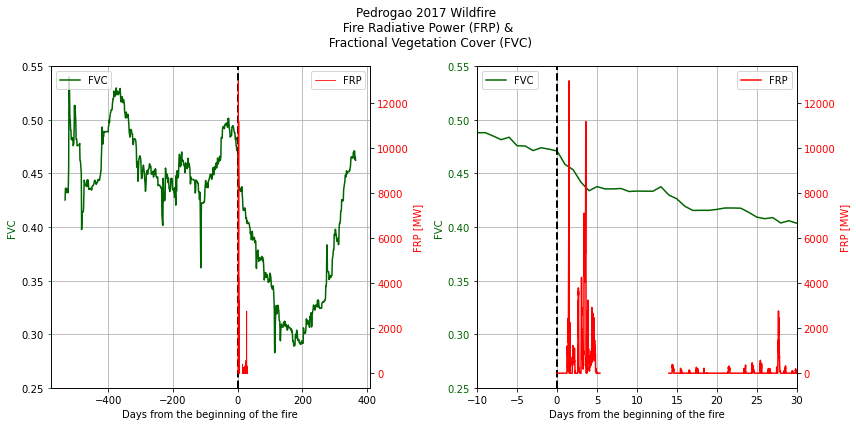

In [11]:
# Define plot colors
FVC_color="darkgreen"
FRP_color="red"

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
ax1.plot(pedrogao_x_FVC, pedrogao_y_FVC, FVC_color, label='FVC')
ax1.set_ylabel('FVC', color=FVC_color)
ax1.set_ylim(0.25, 0.55)
ax1.tick_params(axis='y', color=FVC_color)

ax1_2 = ax1.twinx()
ax1_2.plot(pedrogao_x_FRP, pedrogao_y_FRP, FRP_color, label='FRP', linewidth=0.8)
ax1_2.set_ylabel('FRP [MW]', color=FRP_color)
ax1_2.tick_params(axis='y', labelcolor=FRP_color)


# Plot data on the second subplot
ax2.plot(pedrogao_x_FVC, pedrogao_y_FVC, FVC_color, label='FVC')
ax2.set_ylabel('FVC', color=FVC_color)
ax2.set_ylim(0.25, 0.55)
ax2.tick_params(axis='y', labelcolor=FVC_color)

ax2_2 = ax2.twinx()
ax2_2.plot(pedrogao_x_FRP, pedrogao_y_FRP, FRP_color, label='FRP')
ax2_2.set_ylabel('FRP [MW]', color=FRP_color)
ax2_2.tick_params(axis='y', labelcolor=FRP_color)


# Set the first subplot
ax1.set_xlabel('Days from the beginning of the fire')
ax1.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax1.axhline(y=0, linestyle='dashed', color="grey")
ax1.grid(True)

# Set the second sublot
ax2.set_xlim(-10, 30)
ax2.set_xlabel('Days from the beginning of the fire')
ax2.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax2.axhline(y=0, linestyle='dashed', color="grey")
ax2.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax1_2.legend(loc='upper right')
ax2.legend(loc='upper left')
ax2_2.legend(loc='upper right')


plt.suptitle('Pedrogao 2017 Wildfire \n Fire Radiative Power (FRP) & \n Fractional Vegetation Cover (FVC)')
plt.tight_layout()
plt.show()

We can clearly see, that the FVC decreased from approximately 0.47 to approximately 0.44 in the range of 5 days when the fire was burning. Furthermore, it can be detected, that the FVC reaches smaller values in a year after the fire, compared to the previous year.

But this decline of FVC based on the MSG satellite is so clear only in the case of the really big Pedrogao wildfire. The decrease of FVC is much smaller in the case of the other 2 fires, which we can detect with the following plot:

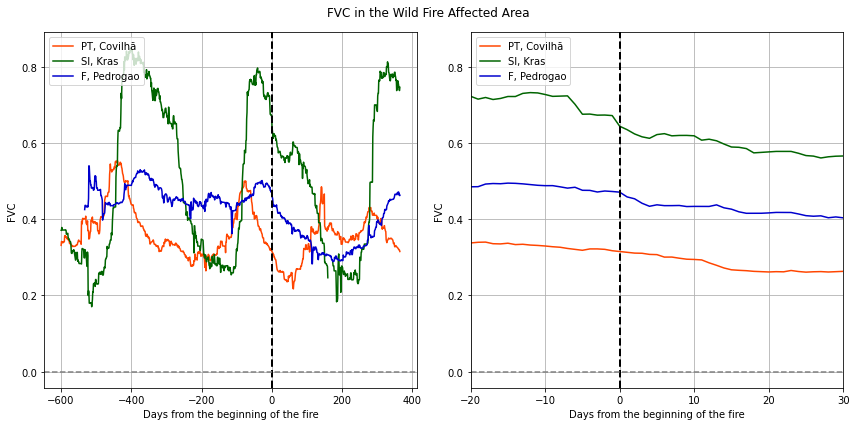

In [12]:
# Define plot colors
FVC_color="darkgreen"
FRP_color="red"

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

FVC_color="darkgreen"
FRP_color="red"



# First subplot
ax1.plot(covilha_x_FVC, covilha_y_FVC, label='PT, Covilhã', color="orangered")
ax1.plot(kras_x_FVC, kras_y_FVC, label="SI, Kras", color='darkgreen')
ax1.plot(pedrogao_x_FVC, pedrogao_y_FVC, label="F, Pedrogao", color='mediumblue')

#Second subplot
ax2.plot(covilha_x_FVC, covilha_y_FVC, label='PT, Covilhã', color="orangered")
ax2.plot(kras_x_FVC, kras_y_FVC, label="SI, Kras", color='darkgreen')
ax2.plot(pedrogao_x_FVC, pedrogao_y_FVC, label="F, Pedrogao", color='mediumblue')
ax2.set_xlim(-20, 30)

# Set the first subplot
ax1.set_ylabel('FVC')
ax1.set_xlabel('Days from the beginning of the fire')
ax1.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax1.axhline(y=0, linestyle='dashed', color="grey")
ax1.grid(True)

# Set the second subplot
ax2.set_ylabel('FVC')
ax2.set_xlabel('Days from the beginning of the fire')
ax2.axvline(x=0, linestyle='dashed', color="black", linewidth=2)
ax2.axhline(y=0, linestyle='dashed', color="grey")
ax2.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.suptitle("FVC in the Wild Fire Affected Area")
plt.tight_layout()
plt.show()

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 23.2.2025
* Ribeiro, L.M., Rodrigues, A., Lucas, D. et. al. (2020) The Impact on Structures of the Pedrógão Grande Fire Complex in June 2017 (Portugal), Fire 2020, 3, 57. [doi:10.3390/fire3040057](https://doi.org/10.3390/fire3040057 )
* Slovenian Government (2022) Poročilo o ukrepanju in intervencijskih stroških gašenja požara v naravnem okolju na območju Krasa od 17. julija do 1. avgusta 2022. [http://vrs-3.vlada.si/MANDAT22/vladnagradiva.nsf/71d4985ffda5de89c12572c3003716c4/8a691ba86ac2ada4c12588c6002df3eb?OpenDocument](http://vrs-3.vlada.si/MANDAT22/vladnagradiva.nsf/71d4985ffda5de89c12572c3003716c4/8a691ba86ac2ada4c12588c6002df3eb?OpenDocument). Accesed: 23.2.2025